In [1]:
# Fuseki IO Development V
## Refinement

# Attach dir one above to handle IDE subdir
import sys, os
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

print(sys.path)
    
import repository
import loader
from rdflib import URIRef, Graph, Namespace

#from models.DMEAR import DMEAR_vis 
from visualize_model import visualize, t2rdflibg, get_field

import gravis as gv

import pandas as pd
import html
import io
import pydotplus
from rdflib.tools.rdf2dot import rdf2dot
from rdflib import URIRef, Graph, Namespace, Literal
from IPython.display import display, Image, HTML
import difflib
from urllib.error import HTTPError
from itertools import product
import re
from datetime import datetime

start = datetime.now()
import text_utils

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/tomk/environment/devpy/lib/python3.10/site-packages', '/home/tomk/Documents/Coding/gitHub/daglit/src', '/home/tomk/Documents/Coding/gitHub/datamodels/src']
Serialization.Meta [Serialization.SerializationMetaData]
Serialization.Serialization [Serialization.SerializationSpecs]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.TranslationMapping [Serialization.SerializationSpecs]
Serialization.MappingKVPair [Serialization.SerializationSpecs]
Serialization.MetaClass [Serialization.Meta]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.MetaProperty [Serialization.Meta]
Serialization.MetaStaticProperty [Serialization.Meta]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaD

* Owlready2 * WARNING: ObjectProperty http://www.tkltd.org/ontologies/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit:/home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpk_jrd94v
* Owlready2 * HermiT took 0.6328587532043457 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    #print(stream.getvalue())
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g

def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [3]:
store_type="jena"
#store_type="memory"
repo = repository.Repository(store_type=store_type)

In [4]:
# Optional Delete data hosted in master and discourse database graphs
do="No"
#do="No"
do_it_anyway = "No"


if do == "Yes" and store_type != "memory":
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)

    
if do_it_anyway == "Yes":
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)
    

In [5]:
cqr=repo.run_cached_query("get_discourse_details.sparql")
cqr

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


[]

In [6]:
do = "Yes"
if do == "Yes":
    repo.truncate_graph(repo.registered_serializations_uri)
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)
    #repo.truncate_graph(repo.ontology_graph_uri)


In [7]:
#### Speed this up!
repo.register_serialization("../src/models/sample/sample_ser.rdf")
repo.register_serialization("../src/models/DMEAR/DMEAR_ser.rdf")

../src/models/sample/sample_ser.rdf
../src/models/DMEAR/DMEAR_ser.rdf


324

In [8]:
g = Graph()
g.parse("../src/models/DMEAR/DMEAR_ser.rdf")

<Graph identifier=N06f13cb9b69749e99a4ac3d2125d5492 (<class 'rdflib.graph.Graph'>)>

In [9]:
rs = g.query("""PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX ser: <http://www.tkltd.org/ontologies/serialization#> 
select ?s ?p ?o
WHERE { ?s ?p ?o. 
VALUES ?p { ser:MappingDomain ser:MappingRange ser:SerializationLabel ser:SerializationParentLabel}}""")

ser_label_set = set([o.toPython() for s,p,o in rs])
ser_label_set

{'Attribute',
 'AttributeDescription',
 'Class',
 'ClassDescription',
 'Context',
 'ContextDescription',
 'DataType',
 'Domain',
 'DomainDescription',
 'FromAttribute',
 'FromCardinality',
 'FromClass',
 'IsPK',
 'Model',
 'ModelDescription',
 'ModelType',
 'Nulls',
 'Relationship',
 'SubContext',
 'ToAttribute',
 'ToCardinality',
 'ToClass'}

In [10]:
rs = repo.ds.query("""PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX ser: <http://www.tkltd.org/ontologies/serialization#> 
select ?s ?p ?o
WHERE { GRAPH <http://config> { ?m ?p ?o. 
?m ser:IsComponentOfSerialization ?s. 
VALUES ?p { ser:MappingDomain ser:MappingRange ser:SerializationLabel ser:SerializationParentLabel}}}""")

ser_label_set = set([(s.toPython(), o.toPython()) for s,p,o in rs])
ser_label_d = dict()
for s,o in ser_label_set:
    if s in ser_label_d.keys():
        ser_label_d[s].add(o)
    else:
        ser_label_d[s]=set([o])

ser_label_d

{'http://www.tkltd.org/serializations/DMEAR': {'Attribute',
  'AttributeDescription',
  'Class',
  'ClassDescription',
  'Context',
  'ContextDescription',
  'DataType',
  'Domain',
  'DomainDescription',
  'FromAttribute',
  'FromCardinality',
  'FromClass',
  'IsPK',
  'Model',
  'ModelDescription',
  'ModelType',
  'Nulls',
  'Relationship',
  'SubContext',
  'ToAttribute',
  'ToCardinality',
  'ToClass'},
 'http://www.tkltd.org/serializations/Sample_Serialisation': {'Class',
  'DataProperty',
  'ParentClass',
  'Property',
  'SubClassPointer'}}

In [11]:
qqr = repo.ds.query("""
select ?g ?s ?p ?o
WHERE { GRAPH ?g { 
?s ?p ?o .
FILTER (?o=<http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#Serialization>) }}""")

In [12]:
pd.DataFrame(qqr).values#.iloc[1].values

array([], shape=(0, 0), dtype=float64)

In [13]:
file_dtypes = {'Domain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'IsPK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}


In [14]:
ser_label_set

{('http://www.tkltd.org/serializations/DMEAR', 'Attribute'),
 ('http://www.tkltd.org/serializations/DMEAR', 'AttributeDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Class'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ClassDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Context'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ContextDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'DataType'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Domain'),
 ('http://www.tkltd.org/serializations/DMEAR', 'DomainDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromAttribute'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromCardinality'),
 ('http://www.tkltd.org/serializations/DMEAR', 'FromClass'),
 ('http://www.tkltd.org/serializations/DMEAR', 'IsPK'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Model'),
 ('http://www.tkltd.org/serializations/DMEAR', 'ModelDescription'),
 ('http://www.tkltd.org/serializations/DMEAR', 'Mode

In [15]:
from datetime import datetime



In [16]:
datetime.now().strftime("%Y-%m-%dT%H:%M")

'2024-02-18T16:54'

In [20]:
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence")
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
datarows

[{'Domain': 'Inventory',
  'Model': 'Inventory',
  'ModelType': 'Physical',
  'Class': 'Product',
  'ClassDescription': 'Individual products and their descriptions',
  'Attribute': 'p_id',
  'AttributeDescription': 'Id field of the product by which it is coded',
  'DataType': 'integer',
  'Context': None,
  'SubContext': None,
  'Nulls': 'No',
  'IsPK': 'Yes',
  'Relationship': None,
  'FromClass': None,
  'FromAttribute': None,
  'FromCardinality': None,
  'ToClass': None,
  'ToAttribute': None,
  'ToCardinality': None},
 {'Domain': 'Inventory',
  'Model': 'Inventory',
  'ModelType': 'Physical',
  'Class': 'Product',
  'ClassDescription': 'Individual products and their descriptions',
  'Attribute': 'p_name',
  'AttributeDescription': 'Name of the product.',
  'DataType': 'string',
  'Context': None,
  'SubContext': None,
  'Nulls': 'No',
  'IsPK': 'No',
  'Relationship': None,
  'FromClass': None,
  'FromAttribute': None,
  'FromCardinality': None,
  'ToClass': None,
  'ToAttribute': 

In [21]:
model_data

,Domain,Model,ModelType,Class,ClassDescription,Attribute,AttributeDescription,DataType,Context,SubContext,Nulls,IsPK,Relationship,FromClass,FromAttribute,FromCardinality,ToClass,ToAttribute,ToCardinality
Sequence,,,,,,,,,,,,,,,,,,,
1,Inventory,Inventory,Physical,Product,Individual products and their descriptions,p_id,Id field of the product by which it is coded,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inventory,Inventory,Physical,Product,Individual products and their descriptions,p_name,Name of the product.,string,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inventory,Inventory,Physical,Location,Facility/Building operated by the organisation,loc_id,Id field of the location.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inventory,Inventory,Physical,Location,Facility/Building operated by the organisation,loc_name,Name by which the location is known.,string,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,loc_id,Identity of the location.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,p_id,Identity of the product.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,p_loc_count,Count of the product at this location.,integer,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Inventory,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inventory --> Product,Inventory,p_id,Many,Product,p_id,Many
9,Inventory,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inventory --> Location,Inventory,loc_id,Many,Location,loc_id,Many


In [17]:
assert False

AssertionError: 

In [22]:
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence")
model_data


,Domain,Model,ModelType,Class,ClassDescription,Attribute,AttributeDescription,DataType,Context,SubContext,Nulls,IsPK,Relationship,FromClass,FromAttribute,FromCardinality,ToClass,ToAttribute,ToCardinality
Sequence,,,,,,,,,,,,,,,,,,,
1,Inventory,Inventory,Physical,Product,Individual products and their descriptions,p_id,Id field of the product by which it is coded,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inventory,Inventory,Physical,Product,Individual products and their descriptions,p_name,Name of the product.,string,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inventory,Inventory,Physical,Location,Facility/Building operated by the organisation,loc_id,Id field of the location.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inventory,Inventory,Physical,Location,Facility/Building operated by the organisation,loc_name,Name by which the location is known.,string,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,loc_id,Identity of the location.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,p_id,Identity of the product.,integer,NaN,NaN,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Inventory,Inventory,Physical,Inventory,Inventory of products located at a location,p_loc_count,Count of the product at this location.,integer,NaN,NaN,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Inventory,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inventory --> Product,Inventory,p_id,Many,Product,p_id,Many
9,Inventory,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inventory --> Location,Inventory,loc_id,Many,Location,loc_id,Many


In [ ]:
mpd = {"created" : "2023-04-11", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 2", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-11"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

In [ ]:
#mpd = {"created" : "2023-04-10", 
#                   "creator" : "tomk", 
#                   "description" : "MDM Datamodel", 
#                   "title" : "MDM Datamodel", 
#                   "modified" : "2023-04-10"}

#metadata_payload = repo.meta_data_package_template( mpd )
#title = "MDM Datamodel"
#model_data = pd.read_csv(r"../sample/mdm_v11_3_pdm_dmear.csv", index_col="Sequence", dtype=file_dtypes)
#datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
#col_set = set(repository.get_variables_from_flat_query_results( datarows))
#match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
#repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

In [ ]:
#assert False

In [ ]:
len(datarows)

In [6]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


""


In [7]:
q="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 

select ?s ?p ?o
    WHERE
    {GRAPH ?g { ?s ?p ?o. }
FILTER (?g=<http://discourse>)
}
"""
q="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 

select ?s ?p ?o
    WHERE
    {GRAPH ?g { ?s ?p ?o. }
FILTER (?g=<http://discourse>)
FILTER (?p=<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>)
FILTER (?o=<http://www.tkltd.org/ontologies/discourse#Discourse>)
}
"""


g = Graph()
rs=repo.ds.query(q)
list(rs)
for t in rs:
    g.add(t)

In [8]:
print(len(g))

6


In [9]:
def isLiteral(r):
    return isinstance(r, Literal) 

def get_defined_types_set(g):
    return set([o for s,p,o in g.triples((None, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), None))])

def get_object_properties_set(g):
    return set([p for s,p,o in g.triples((None, None, None)) if not isLiteral(o)])

def get_literal_properties_set(g):
    return set([p for s,p,o in g.triples((None, None, None)) if isLiteral(o)])


In [10]:
pd.DataFrame(rs)

,0,1,2
0,http://www.tkltd.org/ontologies/21339b0a757045...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...
1,http://www.tkltd.org/ontologies/b44fb8862f184e...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...
2,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...
3,http://www.tkltd.org/ontologies/5384647aafb44a...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...
4,http://www.tkltd.org/ontologies/7deb9411c2764d...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...
5,http://www.tkltd.org/ontologies/db9a929289404c...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.tkltd.org/ontologies/discourse#Disc...


In [11]:
#set([e for b in [(s,o) for s,p,o in g.triples((None, None, None)) if not isLiteral(s) and not isLiteral(o)] for e in b])
discourse_e=list(g.triples((None, None, None)))[0][0]
discourse_e = pd.DataFrame(rs).iloc[0][0]

In [12]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[discourse_e.n3()], native_rdflib=True)
model = URIRef('http://www.tkltd.org/ontologies/214bc10fb39f4a418e44ba9f3ad78803')
pd.DataFrame(qr)
g=Graph()
for row in qr:
        g.add((row['s'], row['p'], row['o']))

print(len(g))

('%%p0%%', '<http://www.tkltd.org/ontologies/21339b0a757045dd9ad49d3511edaaff>')
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?discourse ?assertion ?refutation ?posit ?s ?p ?o
FROM <http://discourse> 
WHERE {

  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?refutation disco:Object ?o.
                   }
        OPTIONAL {

In [13]:
dm_query="""
SELECT ?s ?p ?o
WHERE {
{ ?s a <http://www.tkltd.org/ontologies/datamodel#Class>.
  ?o ?p ?s.
  {SELECT ?o WHERE { ?o a <http://www.tkltd.org/ontologies/datamodel#Relationship>.}}
}
}
"""
dm_rs = g.query(dm_query)
dm_g = Graph()
for row in dm_rs:
        dm_g.add((row['s'], row['p'], row['o']))
len(dm_g)

8

In [14]:
#<http://www.tkltd.org/ontologies/datamodel#Description>
description_query="""
SELECT ?s ?o
WHERE {
 ?s <http://www.tkltd.org/ontologies/datamodel#Description> ?o.
}
"""
description_list = [v for v in list(g.query(description_query))]
description_list


[(rdflib.term.URIRef('http://www.tkltd.org/ontologies/5a34edc0ffa24bd2ae9abb89f0f19987'),
  rdflib.term.Literal('Assigned role to this member of staff')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/f99a8e3897434f4eb9ba375b05ad182b'),
  rdflib.term.Literal('Facility/Building operated by the organisation')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/1810a481ac5a4c9facaa113d3dd0dd52'),
  rdflib.term.Literal('Count of the product at this location.')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/595f381c6f6d4bc3b1935b631b79590d'),
  rdflib.term.Literal('Id number of the staff member.')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/c52718f990bb42edada4add5817c55c0'),
  rdflib.term.Literal('Location base of this member of staff.')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/27f7c559482b45afa110eeba5518ff45'),
  rdflib.term.Literal('Individual products and their descriptions')),
 (rdflib.term.URIRef('http://www.tkltd.org/ontologies/37bf07d

In [15]:
entity_query="""
SELECT ?s 
WHERE {
 ?s a <http://www.tkltd.org/ontologies/datamodel#Class>.
}
"""
entity_list = [v[0] for v in list(g.query(entity_query))]
entity_list

[rdflib.term.URIRef('http://www.tkltd.org/ontologies/e82395098d9b40f3b5c7c0d3458e887e'),
 rdflib.term.URIRef('http://www.tkltd.org/ontologies/37bf07d15e264bdc8c3fb17369bef0c6'),
 rdflib.term.URIRef('http://www.tkltd.org/ontologies/f99a8e3897434f4eb9ba375b05ad182b'),
 rdflib.term.URIRef('http://www.tkltd.org/ontologies/27f7c559482b45afa110eeba5518ff45'),
 rdflib.term.URIRef('http://www.tkltd.org/ontologies/25ac78e9ccdf4bbdbd0a144a31e0a79e')]

In [16]:
q_template={ "self" : "PARAMETER(@selfuri)",
    "contents" : {  "label" : "SPARQL(SELECT ?label WHERE {@selfuri <http://www.w3.org/2000/01/rdf-schema#label> ?label})", 
                    "type" : "SPARQL(SELECT ?type WHERE {@selfuri <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> ?type})",
                    "description" : "SPARQL(SELECT ?description WHERE {@selfuri <http://www.tkltd.org/ontologies/datamodel#Description> ?description})",
                    "identifier" : "SPARQL(SELECT ?identifier WHERE {@selfuri <http://www.tkltd.org/ontologies/serialization#UniqueIdentifier> ?identifier})",
                    "@attributeuri" : "SPARQL(SELECT ?attributeuri WHERE {@selfuri <http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute> ?attributeuri})",
                    "attributes" : { 
                        "self" : "PARAMETER(@attributeuri)",
                        "contents" : {
                            "label" : "SPARQL(SELECT ?label WHERE {@attributeuri <http://www.w3.org/2000/01/rdf-schema#label> ?label})", 
                            "datatype" : "SPARQL(SELECT ?datatype WHERE {@attributeuri <http://www.tkltd.org/ontologies/datamodel#DataType> ?datatype})",
                            "nulls" : "SPARQL(SELECT ?nulls WHERE {@attributeuri <http://www.tkltd.org/ontologies/datamodel#NullsOptional> ?nulls})",
                            "optionality" : "SPARQL(SELECT ?optionality WHERE {@attributeuri <http://www.tkltd.org/ontologies/datamodel#Optionality> ?optionality})",
                            "pk" : "SPARQL(SELECT ?pk WHERE {@attributeuri <http://www.tkltd.org/ontologies/datamodel#isIdentifierForClass> ?pk})",
                            "identifier" : "SPARQL(SELECT ?identifier WHERE {@attributeuri <http://www.tkltd.org/ontologies/serialization#UniqueIdentifier> ?identifier})",
                            "description" : "SPARQL(SELECT ?description WHERE {@attributeuri <http://www.tkltd.org/ontologies/datamodel#Description> ?description})",



                        }
                    }

}
    

}


In [17]:
def to_text(something, context=None):
    if context is None:
        if isinstance(something, (URIRef, Literal)):
            return something.toPython()
        elif isinstance(something, str):
            return something
        else:
            return str(something)
    elif context=="sparql":
        if isinstance(something, (URIRef, Literal)):
            return something.n3()
        elif isinstance(something, str):
            return something
        else:
            return str(something)

def multi_replace(text, replace_parms, parameters):
    for p in replace_parms:
        text=text.replace(p, to_text(parameters.get(p, None), context="sparql"))
    return text

def resolve_content(graph, content, parameters, scope):
    # Given a string, unpack and resolve to some list of results
    # parameters hosts global list of parameter options, while
    # scope contains the current working values being processed
    value_type_rx=re.compile("(SPARQL|PARAMETER)\((.*)\)")
    match_groups=value_type_rx.findall(content)
    if match_groups is not None and len(match_groups)>0:
        m_type, m_value = match_groups[0]
    if m_type.lower()=="parameter":
        r_val = [m_value,parameters.get(m_value, None)]
        return r_val
    elif m_type.lower()=="sparql":
        get_parms_rx=re.compile("\@[\w]*")
        replace_parms = get_parms_rx.findall(m_value)
        query = multi_replace(m_value, replace_parms, scope)
        rs =  g.query(query)
        return [v[0] for v in list(rs)]
    

def qt_dict(graph, template, parameters, scope=None):
    """Run through a node_properties extract template, each section containing a
    self and contents section. 
    The self section defines a key value which is drawn from parameters and assigned to
    the scope. """
    return_d = dict()
    if scope is None:
        scope=dict()
    self_key_content = template.get('self', None)
    
    self_key_name, self_key_list=resolve_content(graph, self_key_content, parameters, scope)
    for key in self_key_list:
        return_d[key]=dict()
        scope[self_key_name]=key
        for header, specification in template.get('contents', {}).items():
            if not isinstance(specification, dict):
                resolved_content=resolve_content(graph, specification, parameters, scope)
                return_d[key][header]=resolved_content
                if header[0]=="@":
                    parameters={**parameters, **{header:resolved_content}}
            else:
                return_d[key][header]=qt_dict(graph, template.get('contents').get(header), parameters, scope)
    return return_d


In [18]:
e1=URIRef('http://www.tkltd.org/ontologies/f333cfb4946a4ce08a30ccb227e6ed76')
e2=URIRef('http://www.tkltd.org/ontologies/8c8a40c3031549d6b56233892cac65bc')

#rs = resolve_content(g, "SPARQL(SELECT ?attributeuri WHERE {@selfuri <http://www.tkltd.org/ontologies/datamodel#ClassContainsAttribute> ?attributeuri})", {"@selfuri" : [e1, e2]}, {"@selfuri" : e1})

qt_d = qt_dict(g, q_template, {"@selfuri" : entity_list}, scope=None)

In [19]:
for i,d in qt_d.items():
    print(i)
    for k,v in qt_d[i].items():
        if isinstance(v, list) and k[0]!="@":
            print ("\t", k, ":", ",".join([l for l in v]))
        if isinstance(v, dict):
            print ("\t", k )
            for kk,vv in v.items():
                for kkk,vvv in vv.items():
                    print ("\t\t", kkk, ":", ". ".join([l for l in vvv]))
                print()
    print()
    

http://www.tkltd.org/ontologies/e82395098d9b40f3b5c7c0d3458e887e
	 label : Staff
	 type : http://www.tkltd.org/ontologies/datamodel#Class
	 description : Members of staff
	 identifier : Inventory.Inventory.Staff
	 attributes
		 label : staff_id
		 datatype : integer
		 nulls : 
		 optionality : No
		 pk : Yes
		 identifier : Inventory.Inventory.Staff.staff_id
		 description : Id number of the staff member.

		 label : role_id
		 datatype : integer
		 nulls : 
		 optionality : No
		 pk : No
		 identifier : Inventory.Inventory.Staff.role_id
		 description : Assigned role to this member of staff

		 label : staff_name
		 datatype : string
		 nulls : 
		 optionality : No
		 pk : No
		 identifier : Inventory.Inventory.Staff.staff_name
		 description : Name of the staff member.

		 label : loc_id
		 datatype : integer
		 nulls : 
		 optionality : No
		 pk : No
		 identifier : Inventory.Inventory.Staff.loc_id
		 description : Location base of this member of staff.


http://www.tkltd.org/ontol

In [20]:
query="""
SELECT ?p ?o
WHERE {
 <http://www.tkltd.org/ontologies/245af8ad3fba4fbaa8db798b8ab1ce46> ?p ?o.
}
"""

query="""
SELECT ?s ?p ?o
WHERE {
 ?s ?p ?o.
 ?s a 
}
"""
pd.DataFrame(g.query(query)).values


ParseException: Expected SelectQuery, found '?'  (at char 37), (line:5, col:2)

In [21]:
pd.DataFrame(qt_d)

,http://www.tkltd.org/ontologies/e82395098d9b40f3b5c7c0d3458e887e,http://www.tkltd.org/ontologies/37bf07d15e264bdc8c3fb17369bef0c6,http://www.tkltd.org/ontologies/f99a8e3897434f4eb9ba375b05ad182b,http://www.tkltd.org/ontologies/27f7c559482b45afa110eeba5518ff45,http://www.tkltd.org/ontologies/25ac78e9ccdf4bbdbd0a144a31e0a79e
label,[Staff],[Inventory],[Location],[Product],[Roles]
type,[http://www.tkltd.org/ontologies/datamodel#Class],[http://www.tkltd.org/ontologies/datamodel#Class],[http://www.tkltd.org/ontologies/datamodel#Class],[http://www.tkltd.org/ontologies/datamodel#Class],[http://www.tkltd.org/ontologies/datamodel#Class]
description,[Members of staff],[Inventory of products located at a location],[Facility/Building operated by the organisation],[Individual products and their descriptions],[Working Roles]
identifier,[Inventory.Inventory.Staff],[Inventory.Inventory.Inventory],[Inventory.Inventory.Location],[Inventory.Inventory.Product],[Inventory.Inventory.Roles]
@attributeuri,[http://www.tkltd.org/ontologies/595f381c6f6d4...,[http://www.tkltd.org/ontologies/2df2ee3c3dde4...,[http://www.tkltd.org/ontologies/1f95ef85e5ff4...,[http://www.tkltd.org/ontologies/bbb60d914c284...,[http://www.tkltd.org/ontologies/4411d361e63f4...
attributes,{'http://www.tkltd.org/ontologies/595f381c6f6d...,{'http://www.tkltd.org/ontologies/2df2ee3c3dde...,{'http://www.tkltd.org/ontologies/1f95ef85e5ff...,{'http://www.tkltd.org/ontologies/bbb60d914c28...,{'http://www.tkltd.org/ontologies/4411d361e63f...


In [ ]:
assert False

In [ ]:



def process_query_template(graph, template, parameters=None, nested=None):
    value_type_rx=re.compile("(SPARQL|PARAMETER)\((.*)\)")
    if nested is None:
        return_d=dict()
    else:
        return_d=nested
    parms_in_scope=dict()
    for k,v in template.items():
        
        if k.lower()=="self":
            ms = value_type_rx.findall(v)
            print(ms)
            if ms is not None:
                pt,pn = ms[0]
                if pt=="PARAMETER":
                    parms_in_scope[pn]=parameters.get(pn)
        elif k.lower=="contents":
            if isinsatance(parameters.get(pn), list):
                for self in parameters.get(pn):
                    return_d[self]=dict()
                    for content_name, content_value in v.items():
                        if content_name[0]!="@":
                            
            


In [ ]:
parameters={"@selfuri":URIRef("http://www.tkltd.org/ontologies/5fb7e400ff1a4fbab5dce88be25714b0")}

In [ ]:
process_query_template(g, q_template, parameters=parameters)

In [ ]:
discourse_df = pd.DataFrame(qr)

In [ ]:
discourse_df.pivot_table(index="s", values="p", aggfunc=len).sort_values(by="p", ascending=False)

In [ ]:
discourse_df[(discourse_df['s']==URIRef('http://www.tkltd.org/ontologies/214bc10fb39f4a418e44ba9f3ad78803'))&
            (discourse_df['p']==URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'))].values

In [ ]:
row['s'], discourse_e

In [ ]:
def cartesian_product_dict_generator(**kwargs):
    k_names=list(kwargs.keys())
    for d in [{k:v[e] for e,k in enumerate(k_names)} for v in product(*kwargs.values())]:
        yield d

In [ ]:
import vis_rdf

In [ ]:
gjgf = vis_rdf.process_graph(dm_g)

In [ ]:
# d3 or three
model_html = gv.d3(gjgf, 
  node_label_data_source='label',
  show_edge_label=True,
  edge_label_size_factor=0.7,
  edge_label_data_source='label',
  edge_curvature=0.25,
 links_force_strength=0.1, 
 links_force_distance=100, 
 use_collision_force=True, 
 collision_force_radius=25, 
 many_body_force_strength=-500,
 ).to_html_partial()

In [ ]:
HTML(model_html)

In [ ]:
assert False

In [ ]:
# d3 or three
model_html = gv.three(gjgf, 
  node_label_data_source='label',
  show_edge_label=True,
  edge_label_size_factor=0.7,
  edge_label_data_source='label',
  edge_curvature=0.25,
 links_force_strength=0.1, 
 links_force_distance=100,
 many_body_force_strength=-500,
 ).to_html_partial()

In [ ]:
HTML(model_html)

In [ ]:
col_shape_val_g = cartesian_product_dict_generator(shape=["circle", "rectangle", "hexagon"], 
                                                   color=["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"] 
                                                   )


In [ ]:
assert False

In [ ]:
mpd = {"created" : "2023-04-11", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 2", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-11"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

In [ ]:
mpd = {"created" : "2023-04-12", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 3", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-12"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"../sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

In [ ]:
mpd = {"created" : "2023-04-13", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 4", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-13"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v4.0"
model_data = pd.read_csv(r"../sample/inventory_v4.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]

col_set = set(repository.get_variables_from_flat_query_results( datarows))
match_ser=loader.match_serialization_from_columns(repo.ds, repo.registered_serializations_uri,col_set)
repo.load_serialization_to_discourse(match_ser, mpd['title'], metadata_payload, datarows)

In [ ]:
assert False

In [48]:
from models.DMEAR import DMEAR_vis_old as DMEAR_vis

In [22]:
repo.discourse_hashes

[]

In [30]:
qq="""
select ?g ?discourse (SAMPLE(?d_label) as ?label) (COUNT(?o) as ?declarations) (COUNT(?child_discourse) as ?sub_discourses) 
FROM <http://discourse>
WHERE  {      
{ 
?discourse <http://www.tkltd.org/ontologies/discourse#DiscourseContains> ?o.     
?discourse a <http://www.tkltd.org/ontologies/discourse#Discourse>.     
OPTIONAL { ?discourse rdfs:label ?d_label. }  
OPTIONAL { ?child_discourse a <http://www.tkltd.org/ontologies/discourse#Discourse>.  
		   ?discourse ?p ?child_discourse }      
?o a <http://www.tkltd.org/ontologies/discourse#Declaration>.       
}  
} 
GROUP BY ?g ?discourse"""

qr = repo.run_adhoc_query(qq)
qr_df = pd.DataFrame(qr)
qr_df

,g,discourse,label,declarations,sub_discourses
0,None,http://www.tkltd.org/ontologies/db9a929289404c...,discourse_pmi_claims,3311,0
1,None,http://www.tkltd.org/ontologies/21339b0a757045...,discourse_Inventory ERD v2.0,195,0
2,None,http://www.tkltd.org/ontologies/5384647aafb44a...,discourse_StaffSales Model,40,0
3,None,http://www.tkltd.org/ontologies/92fb95a6218248...,discourse_Inventory ERD v5.0,494,0
4,None,http://www.tkltd.org/ontologies/7deb9411c2764d...,discourse_StaffSales Mapping,97,0
5,None,http://www.tkltd.org/ontologies/b44fb8862f184e...,discourse_Inventory ERD v3.0,453,0


In [24]:
qr

[]

In [31]:
qi = qr_df.query("label in ['discourse_Inventory ERD v3.0', 'discourse_Inventory ERD v5.0'] ").index.values
qi

array([3, 5])

In [32]:
dict(qr_df.iloc[3])

{'g': None,
 'discourse': 'http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6',
 'label': 'discourse_Inventory ERD v5.0',
 'declarations': 494,
 'sub_discourses': 0}

In [33]:
d1 = qr_df.iloc[qi[0]]['discourse']
d2 = qr_df.iloc[qi[1]]['discourse']
#get_posits_sparql = sparql.replace("%%p1%%", ",".join([d1,d2]))

d1,d2

('http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6',
 'http://www.tkltd.org/ontologies/b44fb8862f184e5caec0e920431e7ae3')

In [34]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[",".join([URIRef(d1).n3(),URIRef(d2).n3()])], native_rdflib=True)
#results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(qr)
#set(dcontents['p'])
dcontents

('%%p0%%', '<http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6>,<http://www.tkltd.org/ontologies/b44fb8862f184e5caec0e920431e7ae3>')
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.tkltd.org/ontologies/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?discourse ?assertion ?refutation ?posit ?s ?p ?o
FROM <http://discourse> 
WHERE {

  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refutation disco:Predicate ?p.
                   ?

,discourse,assertion,refutation,posit,s,p,o
0,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.tkltd.org/ontologies/dbf91969e7c7-6...,None,None,http://www.tkltd.org/ontologies/c1bb193537ae4f...,http://www.tkltd.org/ontologies/datamodel#Attr...,http://www.tkltd.org/ontologies/27f7c559482b45...
1,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.tkltd.org/ontologies/016ebed1e2a3-2...,None,None,http://www.tkltd.org/ontologies/c78d7221437849...,http://www.tkltd.org/ontologies/serialization#...,Inventory.Inventory.Customer.surname
2,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.tkltd.org/ontologies/e5c317aac024-6...,None,None,http://www.tkltd.org/ontologies/0251bd3e540648...,http://www.tkltd.org/ontologies/datamodel#From...,Many
3,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.tkltd.org/ontologies/6bb341ab23f1-1...,None,None,http://www.tkltd.org/ontologies/418f8f3c0e4848...,http://www.tkltd.org/ontologies/datamodel#Desc...,Individual customer identifier.
4,http://www.tkltd.org/ontologies/92fb95a6218248...,http://www.tkltd.org/ontologies/58ede4ea863c-8...,None,None,http://www.tkltd.org/ontologies/57a1ba0eb31a4f...,http://www.tkltd.org/ontologies/datamodel#Desc...,Id field of the product by which it is coded
...,...,...,...,...,...,...,...
942,http://www.tkltd.org/ontologies/b44fb8862f184e...,http://www.tkltd.org/ontologies/45c4b0123bf1-3...,None,None,http://www.tkltd.org/ontologies/f959a44aa71042...,http://www.tkltd.org/ontologies/datamodel#Opti...,No
943,http://www.tkltd.org/ontologies/b44fb8862f184e...,http://www.tkltd.org/ontologies/b1195b27bd05-d...,None,None,http://www.tkltd.org/ontologies/4bb2def0e4024f...,http://www.tkltd.org/ontologies/datamodel#Attr...,http://www.tkltd.org/ontologies/0ca5aa25011b4d...
944,http://www.tkltd.org/ontologies/b44fb8862f184e...,http://www.tkltd.org/ontologies/2eae31696d4f-0...,None,None,http://www.tkltd.org/ontologies/a57815c7995f43...,http://www.tkltd.org/ontologies/datamodel#Data...,integer
945,http://www.tkltd.org/ontologies/b44fb8862f184e...,http://www.tkltd.org/ontologies/5d89e5a6a8c7-4...,None,None,http://www.tkltd.org/ontologies/5988fe7ed3574f...,http://www.tkltd.org/ontologies/serialization#...,Inventory.Inventory.QOrder.quote_date


In [35]:
dcontents['o'].values

array([rdflib.term.URIRef('http://www.tkltd.org/ontologies/27f7c559482b45afa110eeba5518ff45'),
       rdflib.term.Literal('Inventory.Inventory.Customer.surname'),
       rdflib.term.Literal('Many'),
       rdflib.term.Literal('Individual customer identifier.'),
       rdflib.term.Literal('Id field of the product by which it is coded'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/e82395098d9b40f3b5c7c0d3458e887e'),
       rdflib.term.Literal('No'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/27f7c559482b45afa110eeba5518ff45'),
       rdflib.term.Literal('Inventory.Inventory.Staff'),
       rdflib.term.Literal('Proportion of discount to be applied to base price'),
       rdflib.term.Literal('Inventory.Inventory.isInventoryOfItem'),
       rdflib.term.Literal('discount'), rdflib.term.Literal('Yes'),
       rdflib.term.URIRef('http://www.tkltd.org/ontologies/6b5dff90648d413e92b9a54fdc3ae18f'),
       rdflib.term.Literal('Unique Identifier for this qoute/order.

In [36]:

dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [37]:
d1, d2

('http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6',
 'http://www.tkltd.org/ontologies/b44fb8862f184e5caec0e920431e7ae3')

In [38]:
from rdflib.util import from_n3
URIRef(d1)

rdflib.term.URIRef('http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6')

In [39]:
dcd.keys()

dict_keys([rdflib.term.URIRef('http://www.tkltd.org/ontologies/92fb95a62182485aa517e6de04add5e6'), rdflib.term.URIRef('http://www.tkltd.org/ontologies/b44fb8862f184e5caec0e920431e7ae3')])

In [40]:
dcd.get(d1)

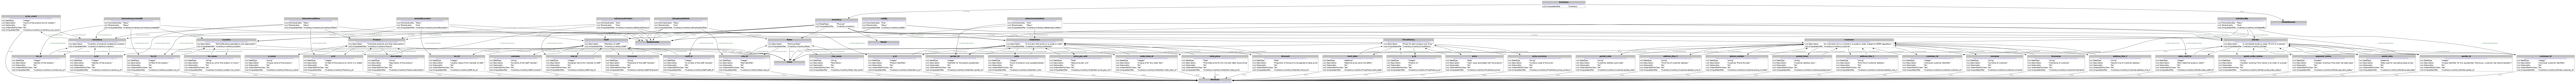

In [41]:
s1 = dcd.get(URIRef(d1))
s2 = dcd.get(URIRef(d2))
visualize(t2rdflibg(s1))

In [42]:
option_dict = { "u_label" : True, 
                "label" : True, 
                "desc" : True, 
                "optionality" : True, 
                "pk" : True, 
                "datatype" : True }

option_dict["optionality"]!=False

True

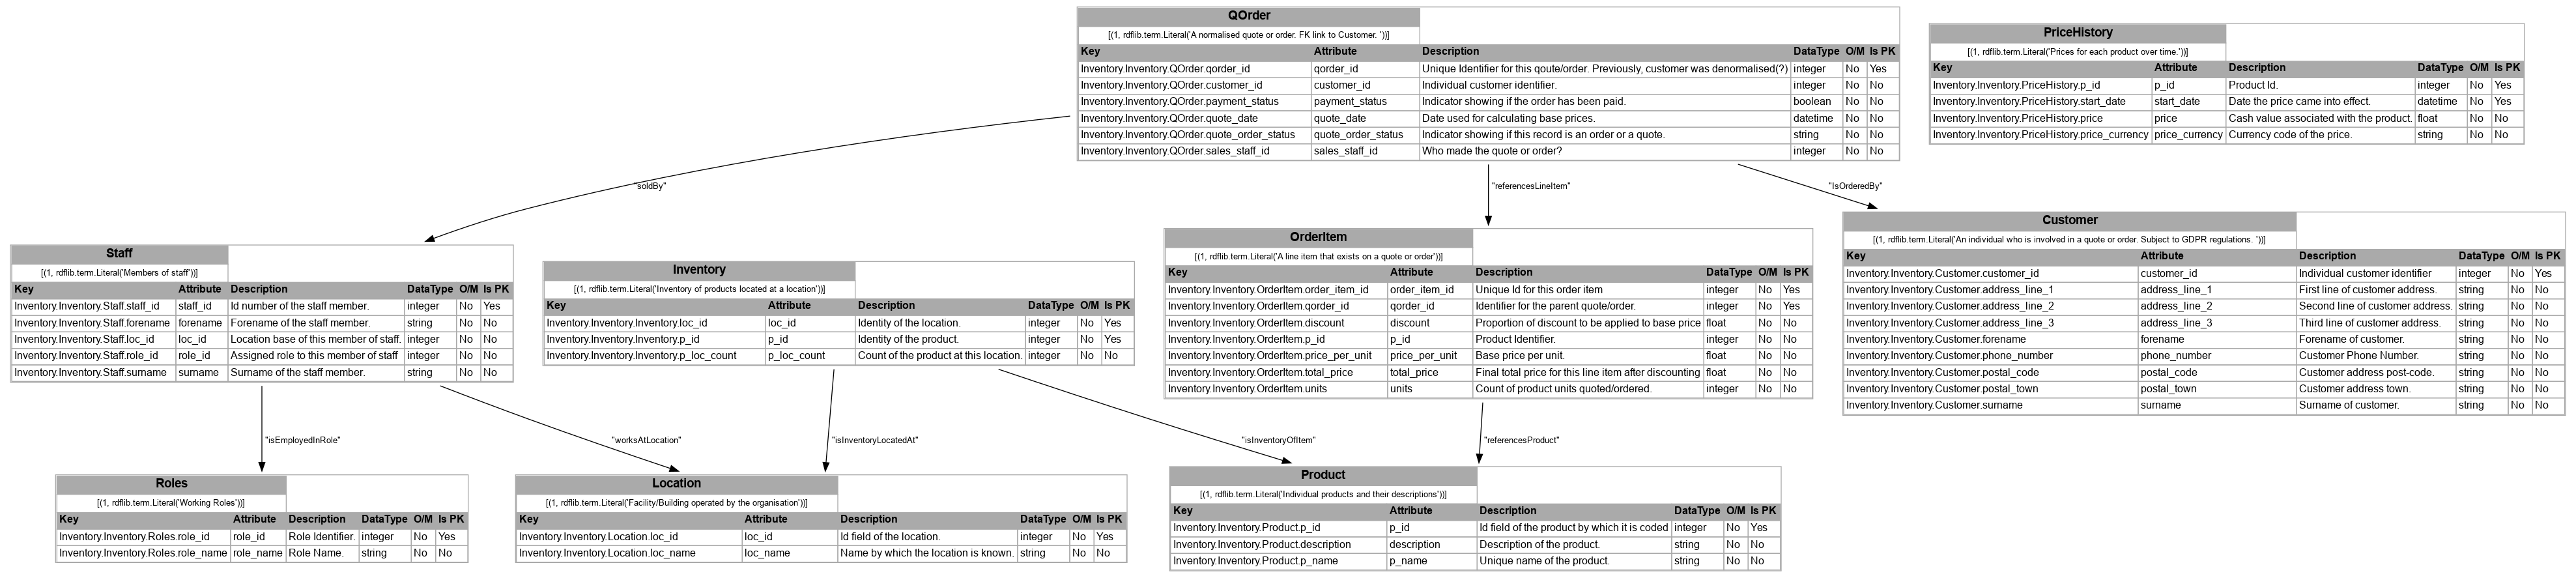

In [49]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, engine="dot", v_type="png")))

In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s2, option_dict, engine="dot", v_type="png")))

In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s2, option_dict, v_type="png")))

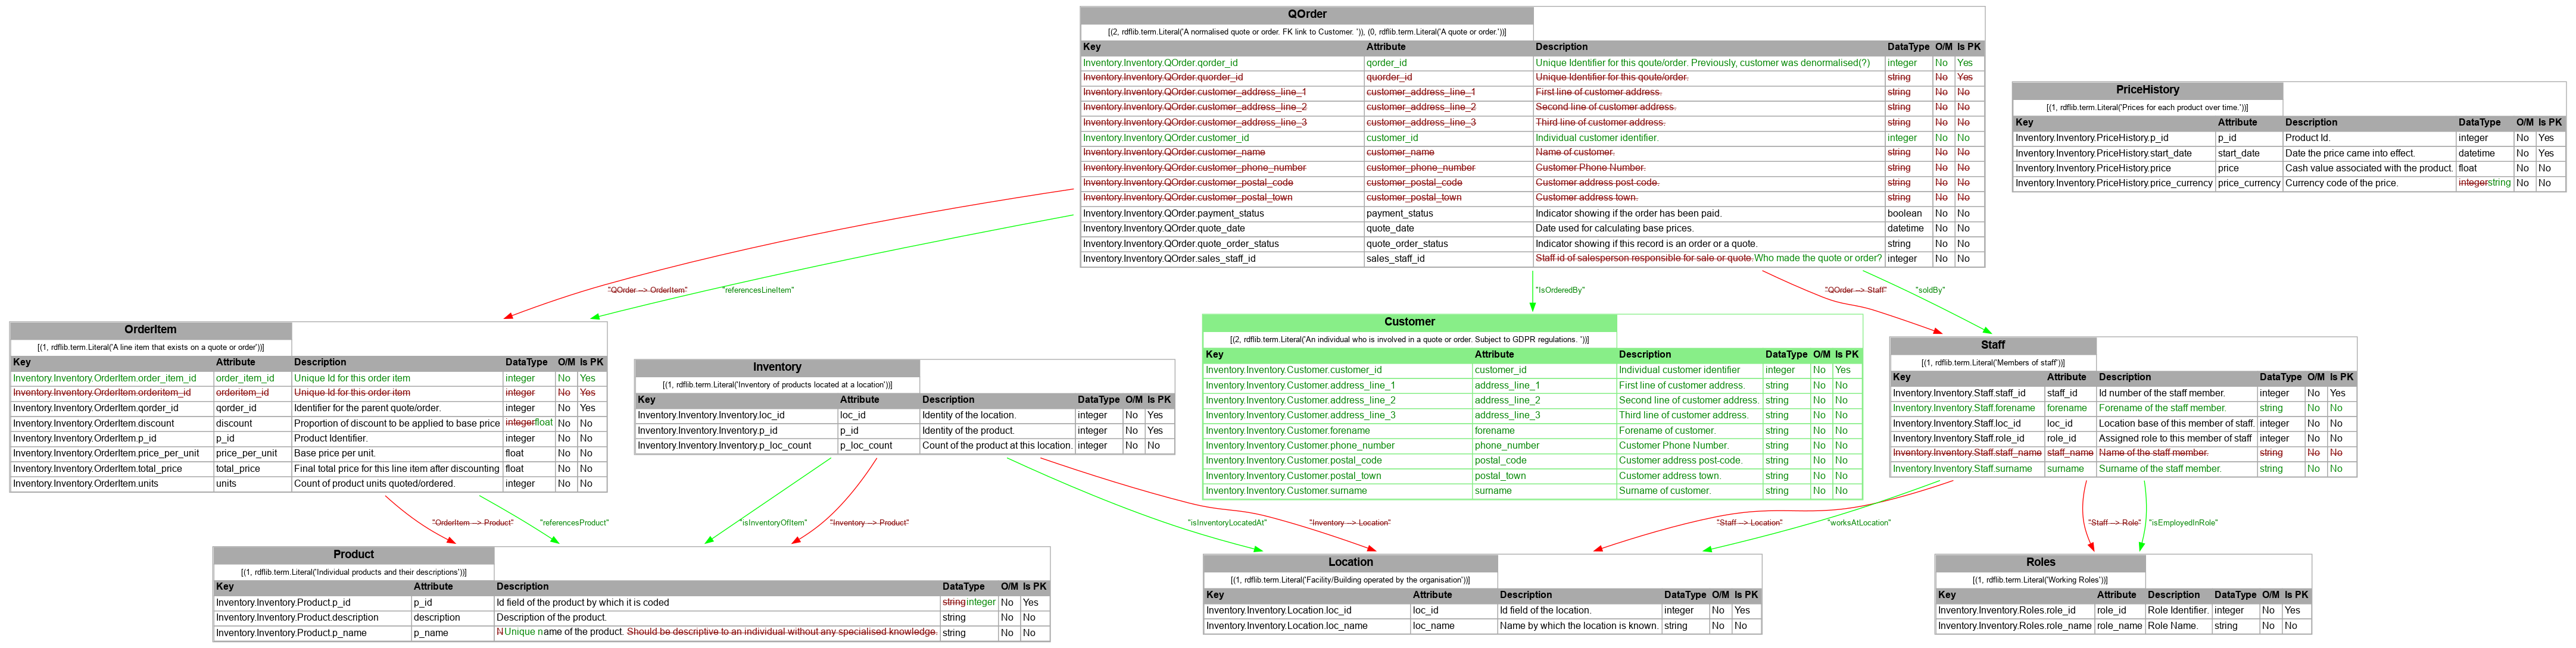

In [51]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s1, option_dict, v_type="png")))

In [ ]:
option_dict = { "u_label" : False, 
                "label" : True, 
                "desc" : True, 
                "optionality" : True, 
                "pk" : True, 
                "datatype" : True }

option_dict["optionality"]!=False

In [ ]:
s1

In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s2, option_dict, v_type="png")))

In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s2, s1, option_dict, v_type="png")))

In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s2, option_dict, engine="dot", graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
assert False

In [ ]:
mpd = {"created" : "2023-09-26", 
                   "creator" : "tomk", 
                   "description" : "IBM MDM Diagram", 
                   "title" : "IBM MDM Diagram", 
                   "modified" : "2023-09-26"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "IBM MDM Diagram v0.1"
model_data = pd.read_csv(r"../sample/mdm_v11_3_pdm_dmear.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

In [ ]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

In [ ]:
qi = qr_df.query("description in ['IBM MDM Diagram'] ").index.values
d1 = qr_df.iloc[qi[0]]['discourse']

In [ ]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[",".join([URIRef(d1).n3()])], native_rdflib=True)
#results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(qr)
#set(dcontents['p'])
dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [ ]:


s1 = dcd.get(URIRef(d1))

In [ ]:
option_dict = { "u_label" : False, 
                "label" : True, 
                "desc" : True, 
                "optionality" : False, 
                "pk" : False, 
                "datatype" : False }


In [ ]:
display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
svg_data=DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="svg")

In [ ]:
with open("svg_test.svg", "w") as f:
    f.write(_.decode("utf-8"))

In [ ]:
HTML(_.decode("utf-8"))

In [ ]:

display(Image(DMEAR_vis.DMEAR_vizdiff_to_graph(s1, s1, option_dict, graph_options={ "pack" : True, "packMode" : "\"node\"" }, v_type="png")))

In [ ]:
assert False

In [ ]:
dot_text = DMEAR_vis.DMEAR_vizdiff_to_dot(s1, s1)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
assert False

In [ ]:
def typed_dictionary_from_triples(triple_set):
    type_d={}
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            if t[2] not in type_d.keys():
                type_d[t[2]]=set([t[0]])
            else:
                type_d[t[2]].add(t[0])
                
    return type_d


def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def sigmoid(x):
    return 1/(1+(e**(-10*(x-0.5))))

def score_diffset(S1,S2):
    l,i,r = diffset(S1, S2)
    ll,il,rl = len(l), len(i), len(r)
    pos=(0.1*ll)+li+(0.6*lr)
    return sigmoid(pos/(ll+il+rl))
    

def LIR_test(triple, LIR_tuple):
    for e,s in enumerate(LIR_tuple):
        if triple in s:
            return e
    return None
    

def property_per_entity(triple_set, entity):
    property_d={}
    for t in triple_set:
        if t[0] == entity:
            if t[1] not in property_d.keys():
                property_d[t[1]]=set([t[2]])
            else:
                property_d[t[1]].add(t[2])
    return property_d

def retrieve_property_meta(triple_set, LIR_tuple, subject, predicate):
    meta_collection=[]
    for s,p,o in triple_set:
        if s==subject and p==predicate:
            LIR_loc=LIR_test((s,p,o), LIR_tuple)
            meta_collection.append((LIR_loc, o))
    return meta_collection
            
    
    

In [ ]:
def DMEAR_vizdiff_to_dot(S1, S2):
    rdf_type_uri = URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
    class_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    relation_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
    attribute_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')
    L, I, R = diffset(S1, S2)
    obj_dict = typed_dictionary_from_triples(S1.union(S2))
    entities=[]
    ent_node_dir={}
    DMEAR_types = [ URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class'),
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
                    ]
    for e,entity in enumerate(obj_dict[class_uri]):
        node_name=f"node_{e}"
        ent_node_dir[entity]=node_name
        def_triple = (entity, rdf_type_uri, class_uri)
        LIR_loc = LIR_test(def_triple, (L,I,R))
        eprops = property_per_entity(S1.union(S2), entity)
        unique_ids = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        labels = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        descriptions = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        content_elements = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'))
        # possible filter on content_elements having type-assignments of Attribute
        attr_elements = []
        for a_lir, attribute in content_elements:
            aprops = property_per_entity(S1.union(S2), attribute)
            a_labels = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
            a_descs = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
            a_dtypes = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'))
            a_uniques = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
            a_optionalities = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Optionality'))
            a_pks = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#isIdentifierForClass'))
            attribute_package = {"uri" : attribute, 
                                 "lir" : a_lir, 
                                 "u_label" : a_uniques, 
                                 "label" : a_labels, 
                                 "desc" : a_descs, 
                                 "optionality" : a_optionalities, 
                                 "pk" : a_pks}
            attr_elements.append(attribute_package)
            
        entity_package = {"uri" : entity, 
                          "node" : node_name, 
                          "lir" : LIR_loc, 
                          "u_label" : unique_ids, 
                          "label" : labels, 
                          "desc" : descriptions, 
                          "attributes" : attr_elements}
        
        entities.append(entity_package)
    
    
    relations=[]
    
    for relation in obj_dict[relation_uri]:
        #print(relation)
        rel_triple = (relation, rdf_type_uri, relation_uri)
        rel_lir = LIR_test(rel_triple, (L,I,R))
        rel_props = property_per_entity(S1.union(S2), relation)
        #for k in rel_props.keys():
        #    print (k)
        rel_from_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass'))
        rel_to_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToClass'))
        rel_from_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromCardinality'))
        rel_to_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToCardinality'))
        rel_from_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute'))
        rel_to_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToAttribute'))
        rel_unique = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        rel_label = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        rel_descs = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        rel_type = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'))
        rel_package = {"uri" : relation, 
                       "lir" : rel_lir, 
                       "u_label" : rel_unique, 
                       "label" : rel_label, 
                       "desc" : rel_descs,
                       "from_class" : rel_from_class, 
                       "to_class" : rel_to_class, 
                       "from_node" : ent_node_dir[rel_from_class[0][1]],
                       "to_node" : ent_node_dir[rel_to_class[0][1]],
                       "from_attribute" : rel_from_attribute, 
                       "to_attribute" : rel_to_attribute, 
                       "from_cardinality" : rel_from_cardinality, 
                       "to_cardinality" : rel_to_cardinality,
                       "rel_type" : rel_type}
        
        relations.append(rel_package)
    
    
    ## Build up entities and relations in dot language

        

    
    #col_dir = { 0 : "'#068806'", 1 : "'#000000'", 2 : "'#880606'"}
    col_dir = { 0 : "RED", 1 : "BLACK", 2 : "GREEN"}
    fg_col_dir = { 0 : "#880606", 1 : "#000000", 2 : "#068806"}
    alt_col_dir = { 0 : "#EE8888", 1 : "#AAAAAA", 2 : "#88EE88"}
    #start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="DejaVu Sans" ] ; \n edge [fontname = "helvetica"]; \n"""
    start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="helvetica" ] ; \n edge [fontname = "helvetica"]; \n"""
     
 
 
    ent_content = ""
    for ents in entities:
        att_content=""
        
        node, col, alt_col, label, uri, desc = ents["node"], col_dir[ents["lir"]], alt_col_dir[ents["lir"]], ents["label"][0][1], ents["uri"], ents["desc"]
                    
        #"<br/>".join(text_utils.ww(html.escape(ents["desc"][0][1]),40))
            
        if len (ents["attributes"])>0:
            # Set header for attribute table
            attrstr = f"""<tr><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Attribute</B></font></td><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Identifier</B></font></td></tr>"""
            att_content=att_content+attrstr
        #print([(x[6][0][1].n3(), x[3][0][1].n3())for x in ents[6]])
        e_sort={"\"Yes\"":0, "\"No\"": 1}
        for att in sorted(ents["attributes"], key=lambda x : (e_sort[x["pk"][0][1].n3()], x["u_label"][0][1].n3())):
            attr=att["label"][0][1]
            pk=att["pk"][0][1]
            attr_lir = att["lir"]
            
            attr_col=fg_col_dir[attr_lir]
            #print(attr_col)
            if attr_lir != 0:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'>{attr}</font></td><td align='left'><font point-size='12' color='{attr_col}'>{pk}</font></td></tr>"""
            else:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'><s>{attr}</s></font></td><td align='left'><font point-size='12' color='{attr_col}'><s>{pk}</s></font></td></tr>"""
            att_content=att_content+attrstr
        
        #print(label, col)

        entstr = f"""{node} [ shape=none, color={col} label=< <table color='{alt_col}'
         cellborder='1' cellspacing='0' border='1'><tr>
        <td colspan='2' bgcolor='{alt_col}'><B>{label}</B></td></tr><tr>
        <td href='{uri}' bgcolor='#ffffff' colspan='2' ALIGN='center'>
        <font point-size='10' color='#000000'>{desc}</font>
        </td>
        </tr>{att_content}</table> > ] \n"""

        ent_content = ent_content + entstr
            
    
    relstr = ""

    
    for rels in relations:
        fromnode, tonode, rel_col, rel_label = rels["from_node"], rels["to_node"], col_dir[rels["lir"]], rels["label"][0][1].n3()
        fg_rel_col = fg_col_dir[rels["lir"]]
        if rels["lir"]!=0:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'>{rel_label}</font> > ] ;\n"""
        else:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'><s>{rel_label}</s></font> > ] ;\n"""
        
    return start  + relstr + ent_content + "}"

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s1, s1)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s1, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s1)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
timestamp = datetime.now()

elapsed = timestamp - start
print(elapsed)

In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
node.get_pos()

In [ ]:
dg.create_dot()

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
import difflib

In [ ]:
a = "Mary had a little lamb. Its fleece as white as snow."
b = "Sue had a little puppy. Its eyes as dark as night."

In [ ]:
diffs = difflib.SequenceMatcher(None, a,b)

In [ ]:
diffs.a

In [ ]:
diffs.b

In [ ]:
from IPython.display import display
from IPython.display import HTML

In [ ]:
output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

In [ ]:
from IPython.display import display
from IPython.display import HTML

In [ ]:
a = "This text starts the same. And ends the same way."
b = "This text starts the same, but includes a section that deviates from the original before ending the same way."

In [ ]:
def markup_text_diffs(text_a, text_b):

    diffs = difflib.SequenceMatcher(None, text_a,text_b)

    output=""
    for c, i1, i2, j1, j2 in diffs.get_opcodes():
        if c in ["replace", "delete"]:
            #print(c, b[j1:j2])
            output=output+"<font color=\"red\"><s>"+text_a[i1:i2]+"</s></font>"+"<font color=\"green\">" + text_b[j1:j2]+"</font>"
        elif c in "insert":
            #print(c, b[j1:j2])
            output=output+"<font color=\"green\">" + text_b[j1:j2]+"</font>"
        else:
            #print(c, b[j1:j2])
            output=output+text_b[j1:j2]
    return output

        

In [ ]:
a = "Mary yearned for a little lamb its fleece as white as snow."
b = "Many years ago, a little bird lived in a tree. What did it know."
output = markup_text_diffs(a, b)
display(HTML(output))

In [ ]:
diffs.get_opcodes()

In [ ]:
output

In [ ]:
a = "Mary yearned for a little lamb its fleece as white as snow."
b = "Many years ago, a little bird lived in a tree. What did it know."
output = markup_text_diffs(b, b)
display(HTML(output))

In [ ]:
HTML(DMEAR_vis.markup_text_diffs(a,b,{ 0 : "#880606", 1 : "#000000", 2 : "#068806", 3 : "#BB3333"}))